IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Dataset size: (96, 9)


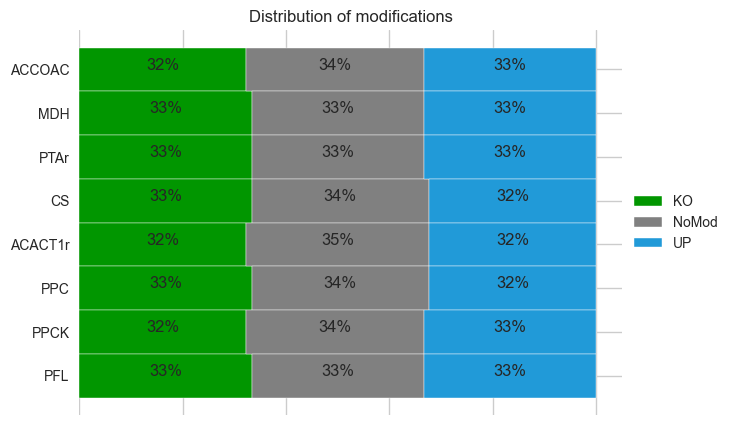

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd

from src import plot_multiomics
from straindesignxai.main import DataLoader

file_path = "../data/EDD_isoprenol_production.csv"
model_path = "../models/xgb_isoprenol.pkl"

input_var = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
response_var = ["Value"]

d = DataLoader(file_path, input_var, response_var)
plot_multiomics.plot_distribution_of_designs(d.df.drop("Value", axis=1))

In [2]:
# How many designs improve production over the WT
print(
    len(d.df[d.df["Value"] > d.df.loc["WT"]["Value"]]),
    "designs out of",
    len(d.df),
    "improve production over the WT",
)

11 designs out of 96 improve production over the WT


[18:53:46] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



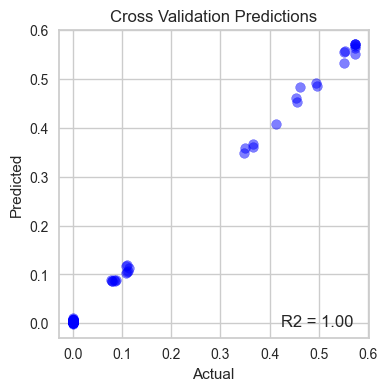

In [3]:
# load or train ml model
try:
    d.load_model(model_path)
except FileNotFoundError:
    d.train_xgb(n_iter=500)
    d.save_model(model_path)

d.plot_R2()

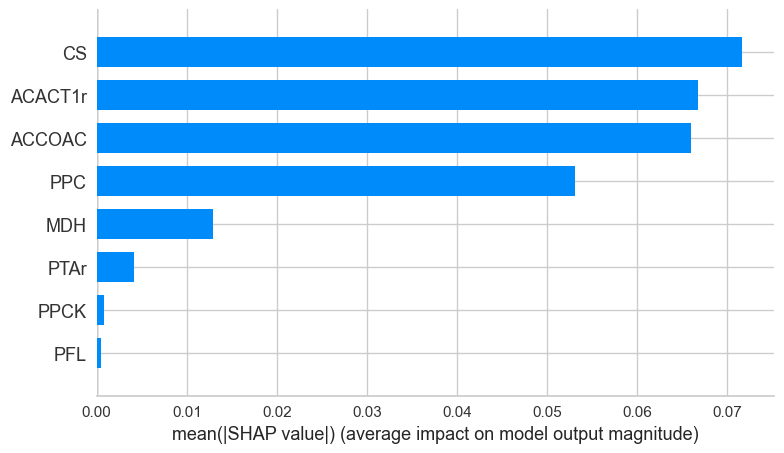

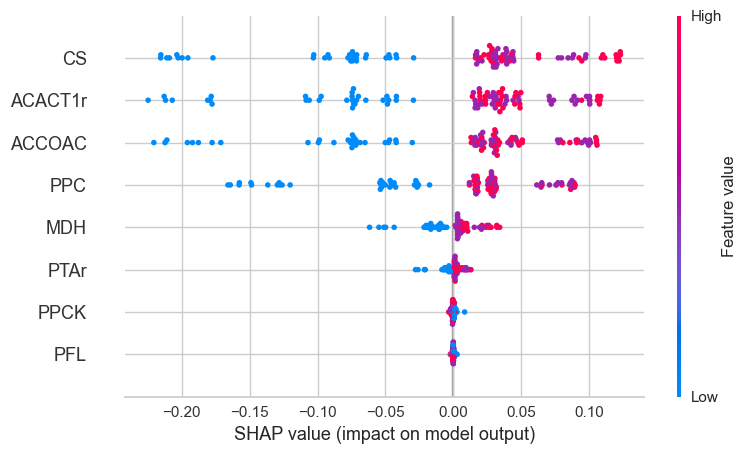

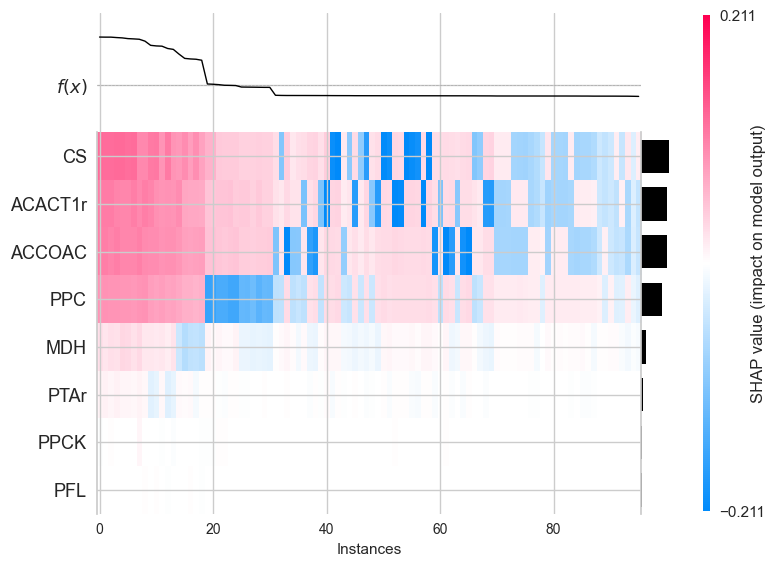

In [4]:
d.get_shap_values()

### Sort columns of `shap_df` by absolute `mean`/`man` shap values

In [5]:
# Sort columns of d.shap_df by mean absolute shap value
d.shap_df = d.shap_df.reindex(
    np.abs(d.shap_df).mean().sort_values(ascending=False).index, axis=1
)
np.abs(d.shap_df).describe().loc["max"]

CS         0.215608
ACACT1r    0.224800
ACCOAC     0.220575
PPC        0.166008
MDH        0.061654
PTAr       0.027843
PPCK       0.008366
PFL        0.002814
Name: max, dtype: float64

### Supervised clustering

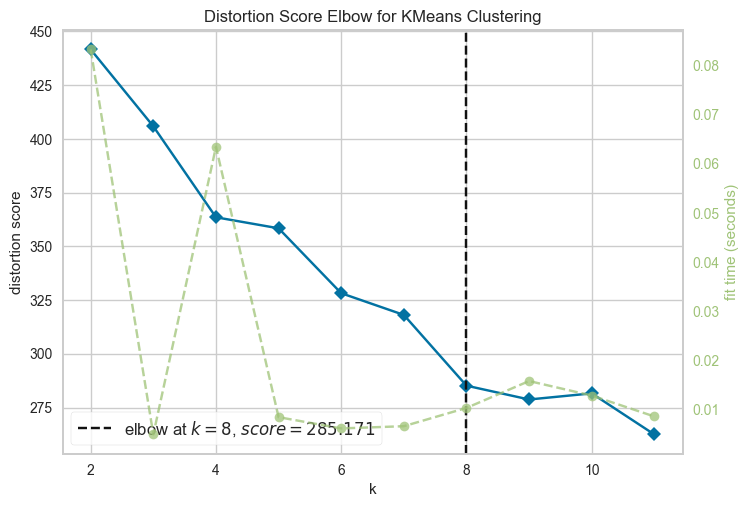

Optimal number of clusters: 8


In [6]:
d.supervised_clustering()

In [7]:
d.df["pred"] = d.model.predict(d.df.drop(["Value", "cluster"], axis=1))
# find cluster with highest mean predicted value
top_cluster = (
    d.df.groupby("cluster").mean().sort_values("pred", ascending=False).index[0]
)
d.df[d.df["cluster"] == top_cluster]

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value,cluster,pred
Line Name,,,,,,,,,,,
Strain 2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.552101,6,0.554696
Strain 4,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.551849,6,0.533084
Strain 7,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.572648,6,0.571667
Strain 17,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.495097,6,0.492459
Strain 41,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.572648,6,0.564361
Strain 46,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.572648,6,0.572483
Strain 48,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.572648,6,0.567612
Strain 49,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.572648,6,0.571661
Strain 53,2.0,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.456256,6,0.453333


### Partial Dependence and Scatter Plots

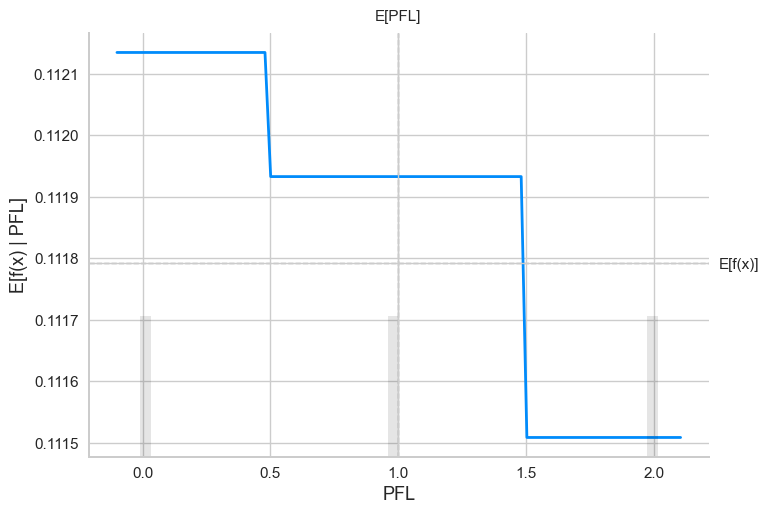

In [8]:
d.pdplot("PFL")

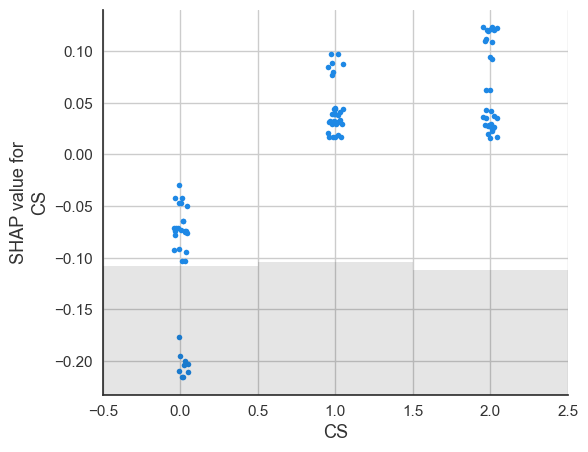

In [9]:
d.shap_scatter("CS")

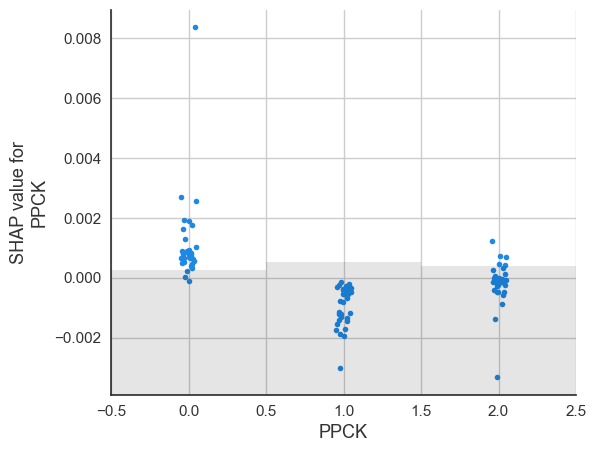

In [10]:
d.shap_scatter("PPCK")

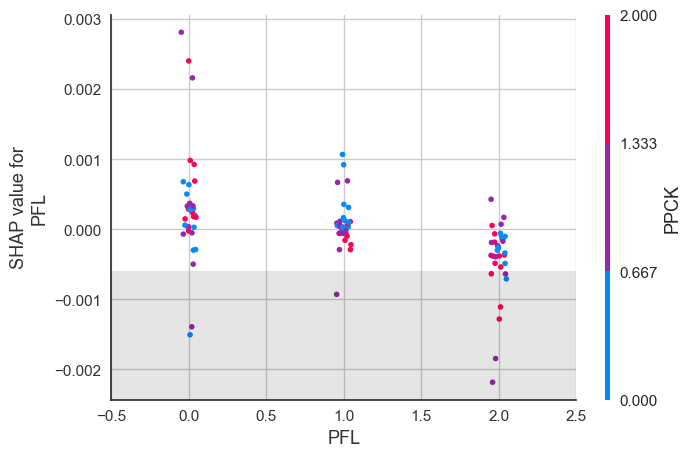

In [11]:
d.shap_scatter("PFL", "PPCK")

### Sampling

In [33]:
import pymc as pm



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
clstr_df = d.study_clusters("most_frequent", verbose=False)
clstr_df.sort_values("pred", ascending=False, inplace=True)
clstr_df = clstr_df.head(1)

bounds = pd.DataFrame(index=d.X.columns, columns=["lower", "upper"])
# bounds.loc['CS'] = [0, 2]
for col in d.X.columns:
    l_b = clstr_df[col].values[0] - 1
    u_b = clstr_df[col].values[0]
    bounds.loc[col] = [l_b, u_b]

# Gerate samples from a Latin hypercube generator
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=d.X.shape[1])
sample = sampler.random(100000)
LB = bounds["lower"].values.tolist()
UB = bounds["upper"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=d.X.columns)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = d.model.predict(sample_df)
# Drop duplicates
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
258,1,2,1,2,1,1,0,1,0.570705
726,1,2,1,2,1,1,0,2,0.569201
325,1,2,1,2,1,1,1,2,0.564361
1015,1,2,1,2,1,1,1,1,0.562735
271,1,1,1,2,1,1,0,1,0.554392
...,...,...,...,...,...,...,...,...,...
391,0,1,1,2,0,0,1,1,-0.000839
86,0,1,1,2,0,0,1,2,-0.000839
74,0,1,1,2,0,0,0,2,-0.000839
151,0,1,0,2,0,0,1,2,-0.001067


In [14]:
bounds

,lower,upper
ACCOAC,0.0,1.0
MDH,1.0,2.0
PTAr,0.0,1.0
CS,1.0,2.0
ACACT1r,0.0,1.0
PPC,0.0,1.0
PPCK,0.0,1.0
PFL,1.0,2.0


### Sampling

In [34]:
top_df = d.df[d.df["cluster"] == top_cluster].copy()

df_x_train = top_df.drop(["Value", "cluster", "pred"], axis=1)
df_y_train = pd.DataFrame(top_df["Value"])

discrete_columns = df_x_train.columns.tolist()

In [1]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=100)
ctgan.fit(df_x_train, discrete_columns)

NameError: name 'df_x_train' is not defined

In [28]:
synthetic_data = ctgan.sample(100)
synthetic_data["pred"] = d.model.predict(synthetic_data)
synthetic_data.sort_values("pred", ascending=False)

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,pred
68,2.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0,0.592842
14,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.589733
84,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.589733
2,2.0,2.0,2.0,2.0,1.0,2.0,0.0,1.0,0.583014
18,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,0.577001
...,...,...,...,...,...,...,...,...,...
69,1.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.361060
99,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.356665
97,1.0,0.0,2.0,1.0,1.0,1.0,1.0,2.0,0.350796
28,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.347708
